In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import math

In [2]:
src_base_w = 32
src_base_h = 32
iso_base_w = 64 * 2
iso_base_h = 32 * 2

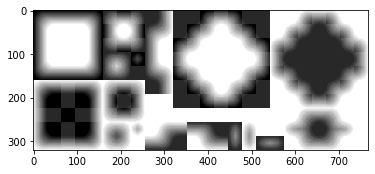

[0, 8, 16, 24, 32, 40, 43, 48, 50, 56, 63, 64, 70, 72, 76, 80, 83, 88, 90, 96, 103, 104, 110, 112, 116, 120, 123, 128, 130, 136, 143, 144, 149, 152, 156, 160, 163, 168, 169, 176, 183, 184, 189, 192, 196, 200, 203, 208, 209, 216, 223, 224, 229, 232, 236, 240, 243, 248, 249, 256]


array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [3]:
img_filename = 'landh-tiles/TilesTest.png'
hmap = None
with Image.open(img_filename) as im_v:
    rgb_im_v = im_v.convert('RGBA')
    pixels = rgb_im_v.load()

    hmap = np.zeros(im_v.size)
    levels_of_gray = set()

    for sy in range(rgb_im_v.size[1]):
        for sx in range(rgb_im_v.size[0]):
            c = r, g, b, a = pixels[sx, sy]
            vmap = max(r, g, b)
            if vmap <= 1:   vmap = 0
            if vmap >= 255: vmap = 256
            levels_of_gray.add(vmap)

            num_gray_levels = 32
            vmap = int(min(num_gray_levels - 0, vmap * num_gray_levels / 256 )) * 256 // num_gray_levels

            levels_of_gray.add(vmap)
            hmap[sx, sy] = float(vmap / 256.)
            pixels[sx, sy] = (vmap, vmap, vmap, 255)

plt.imshow(rgb_im_v)
plt.show()

del rgb_im_v
del pixels

print(sorted(levels_of_gray))

hmap

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def bezier_gradient(ref_colors, output_num=100):
    n_ref = len(ref_colors) - 1

    fact_cache = {}
    def fact(n):
        ''' Memorized factorial function '''
        try:
            return fact_cache[n]
        except(KeyError):
            if n == 1 or n == 0:
                result = 1
            else:
                result = n*fact(n-1)
            fact_cache[n] = result
            return result

    def bernstein(t, n, i):
        ''' Bernstein coefficient '''
        binom = fact(n)/float(fact(i)*fact(n - i))
        return binom*((1-t)**(n-i))*(t**i)

    def bezier_interp(t):
            ''' Define an interpolation function
                for this specific curve'''
            # List of all summands
            summands = [
                list(map(lambda x: int(bernstein(t, n_ref, i)*x), c)) for i, c in enumerate(ref_colors)
            ]

            # Output color
            out = [0,0,0]
            # Add components of each summand together
            for vector in summands:
                for c in range(3):
                    out[c] += vector[c]

            return out

    gradient = [
        bezier_interp(float(t)/(output_num-1)) for t in range(output_num)
    ]
    return gradient

ref_colors = [(0,0,255), (0, 230, 64), (255, 203, 5)]

print(ref_colors)
num_colors = 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

[(0, 0, 255), (0, 230, 64), (255, 203, 5)]
[[0, 0, 255], [1, 28, 229], [4, 56, 205], [10, 81, 183], [18, 103, 162], [28, 124, 141], [40, 142, 121], [55, 158, 104], [72, 171, 87], [91, 183, 71], [113, 192, 58], [137, 198, 45], [163, 202, 33], [191, 205, 21], [222, 204, 12], [255, 203, 5]]


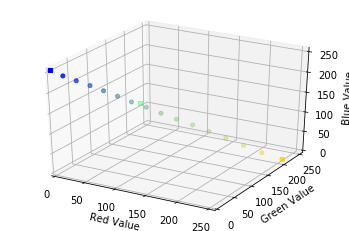

In [5]:
def hex_to_RGB(hex):
    ''' "#FFFFFF" -> [255,255,255] '''
    # Pass 16 to the integer function for change of base
    return [int(hex[i:i+2], 16) for i in range(1,6,2)]


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
                        "{0:x}".format(v) for v in RGB])

def color_dict(gradient):
    ''' Takes in a list of RGB sub-lists and returns dictionary of
        colors in RGB and hex form for use in a graphing function
        defined later on '''
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def control_points_from_colors(gradient):
    return {"hex": [RGB_to_hex(RGB) for RGB in gradient],
            "r":   [RGB[0] for RGB in gradient],
            "g":   [RGB[1] for RGB in gradient],
            "b":   [RGB[2] for RGB in gradient]}

def plot_gradient_series(color_dict, pointsize=100, control_points=None, filename=None):
        ''' Take a dictionary containing the color
            gradient in RBG and hex form and plot
            it to a 3D matplotlib device '''

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        xcol = color_dict["r"]
        ycol = color_dict["g"]
        zcol = color_dict["b"]

        # If bezier control points passed to function,
        # plot along with curve
        if control_points != None:
            xcntl = control_points["r"]
            ycntl = control_points["g"]
            zcntl = control_points["b"]
            ax.scatter( xcntl, ycntl, zcntl,
                        c=control_points["hex"],
                        s=pointsize, marker='s')

        # We can pass a vector of colors corresponding to each point
        ax.scatter(xcol, ycol, zcol, c=color_dict["hex"], s=pointsize)

        ax.set_xlabel('Red Value')
        ax.set_ylabel('Green Value')
        ax.set_zlabel('Blue Value')
        ax.set_zlim3d(0,255)
        plt.ylim(0,255)
        plt.xlim(0,255)

        if not filename is None:
            # Save two views of each plot
            ax.view_init(elev=15, azim=68)
            plt.savefig(filename + ".svg")
            ax.view_init(elev=15, azim=28)
            plt.savefig(filename + "_view_2.svg")

        # Show plot for testing
        plt.show()

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

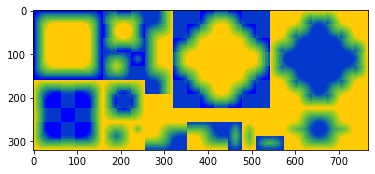

In [6]:
img = Image.new('RGBA', hmap.shape, color = 'black')
pixels = img.load()
max_x, max_y = img.size

for y in range(max_y):
	for x in range(max_x):
		v = int(hmap[x, y] * len(gradient))
		r, g, b = gradient[min(v, len(gradient)-1)]
		pixels[x, y] = (r, g, b, 255)

plt.imshow(img)
plt.show()

del pixels
del img

In [7]:
import csv

tiles_info = []
with open('landh-tiles/TilesTest.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        tiles_info.append(row)
        line_count += 1
    print(f'Processed {line_count} lines.')
    print(f'Found {len(tiles_info)} tiles.')

Column names are TileName, XCoord, YCoord, Comment
Processed 73 lines.
Found 72 tiles.


OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '7'), ('Comment', 'Floor')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


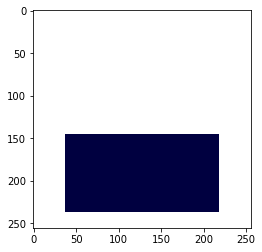

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '2'), ('Comment', 'Plateau')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


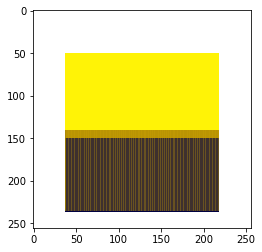

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '0'), ('Comment', 'Descending N-S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


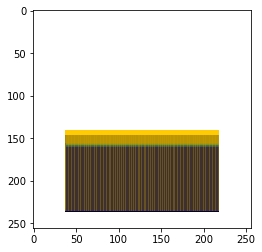

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '4'), ('Comment', 'Descending S-N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


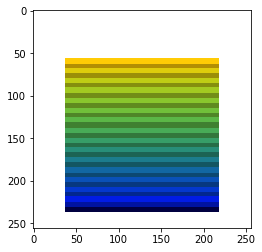

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '2'), ('Comment', 'Descending W-E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


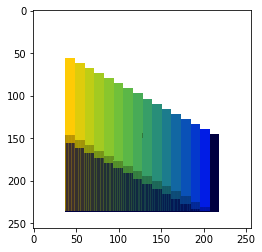

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '2'), ('Comment', 'Descending E-W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


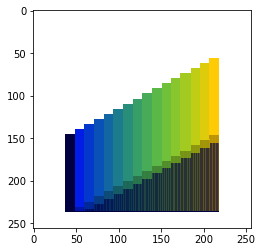

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '0'), ('Comment', 'Ascending Corner NW-SE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


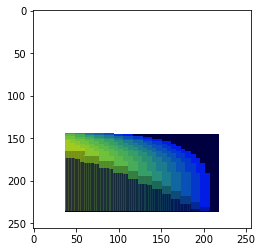

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '0'), ('Comment', 'Ascending Corner NE-SW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


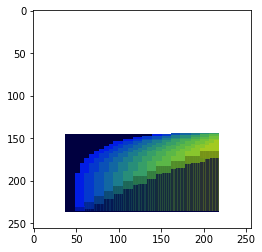

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '4'), ('Comment', 'Ascending Corner SW-NE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


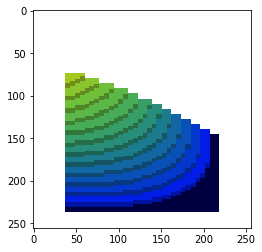

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '4'), ('Comment', 'Ascending Corner SE-NW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


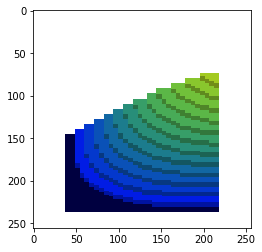

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '5'), ('Comment', 'Descending Corner NW-SE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


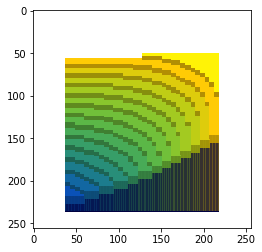

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '5'), ('Comment', 'Descending Corner NE-SW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


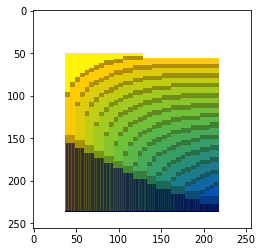

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '9'), ('Comment', 'Descending Corner SW-NE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


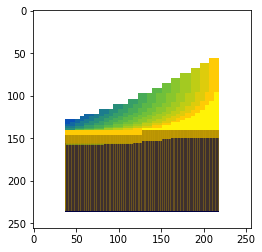

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '9'), ('Comment', 'Descending Corner SE-NW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


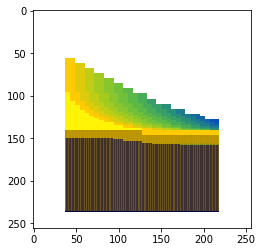

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '1'), ('Comment', 'Ascending Corner NWW-E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


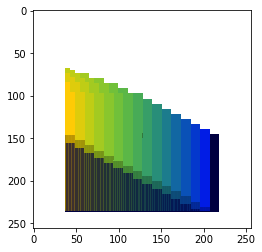

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '1'), ('Comment', 'Ascending Corner NEE-W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


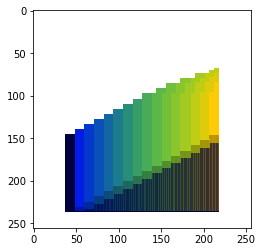

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '3'), ('Comment', 'Ascending Corner SWW-E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


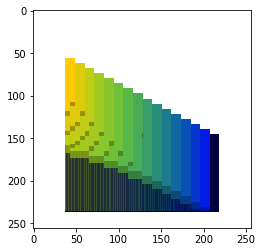

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '3'), ('Comment', 'Ascending Corner SEW-W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


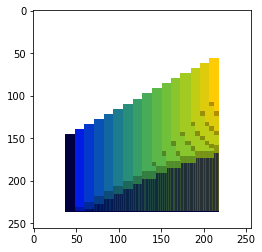

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNW-S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


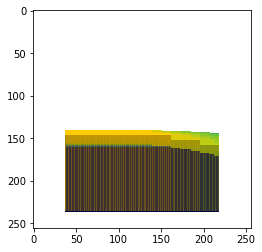

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNE-S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


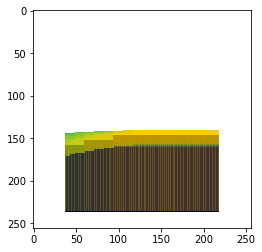

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSW-N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


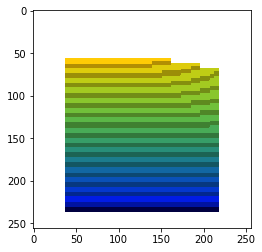

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSE-N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


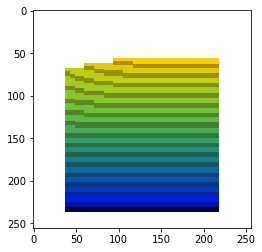

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '6'), ('Comment', 'Descending Corner NWW-E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


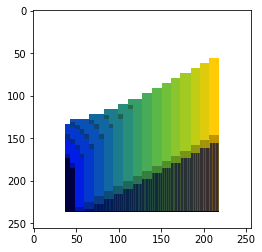

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '6'), ('Comment', 'Descending Corner NEE-W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


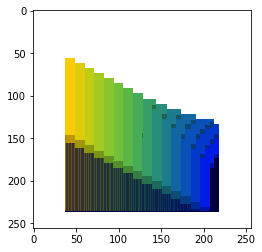

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '8'), ('Comment', 'Descending Corner SWW-E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


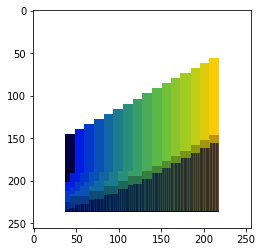

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '8'), ('Comment', 'Descending Corner SEW-W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


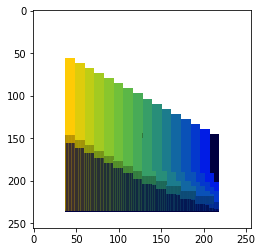

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '5'), ('Comment', 'Descending Corner NNW-S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


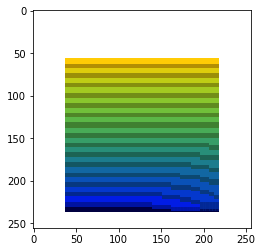

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '5'), ('Comment', 'Descending Corner NNE-S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


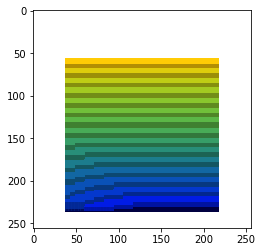

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '9'), ('Comment', 'Descending Corner SSW-N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


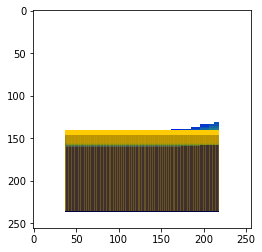

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '9'), ('Comment', 'Descending Corner SSE-N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


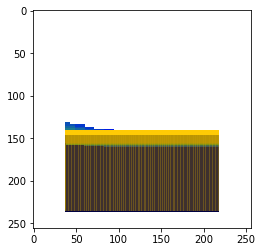

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '1'), ('Comment', 'Plateau NW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


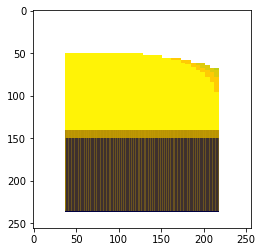

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '1'), ('Comment', 'Plateau NE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


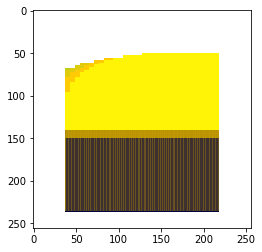

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '3'), ('Comment', 'Plateau SW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


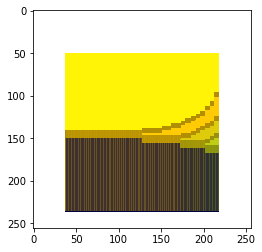

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '3'), ('Comment', 'Plateau SE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


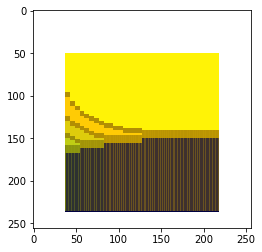

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '6'), ('Comment', 'Floor NW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


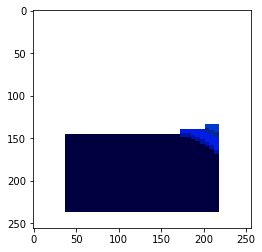

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '6'), ('Comment', 'Floor NE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


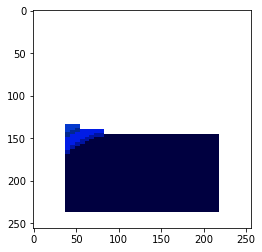

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '8'), ('Comment', 'Floor SW')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


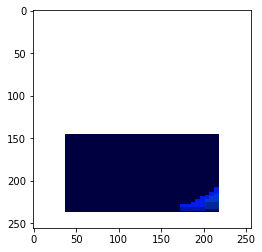

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '8'), ('Comment', 'Floor SE')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


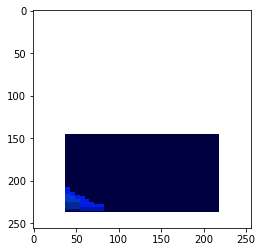

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '0'), ('Comment', 'Ascending Corner N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


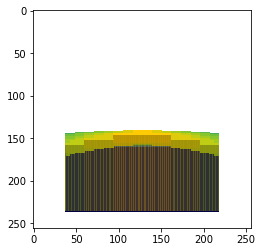

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '2'), ('Comment', 'Ascending Corner S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


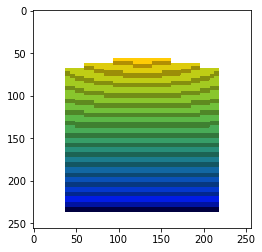

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '1'), ('Comment', 'Ascending Corner W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


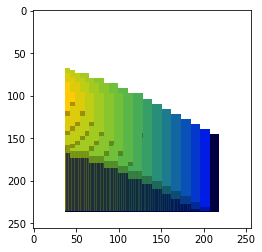

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '1'), ('Comment', 'Ascending Corner E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


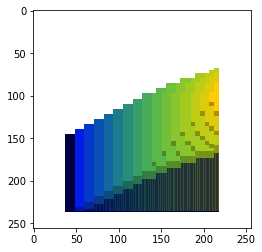

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '5'), ('Comment', 'Descending Corner N')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


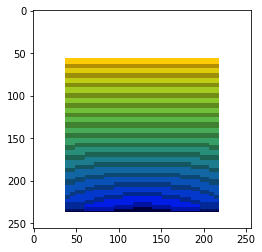

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '7'), ('Comment', 'Descending Corner S')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


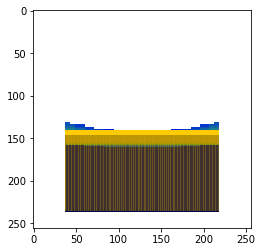

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '6'), ('Comment', 'Descending Corner W')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


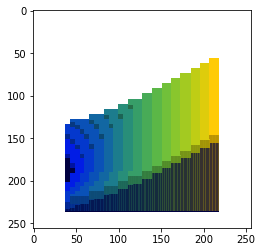

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '6'), ('Comment', 'Descending Corner E')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


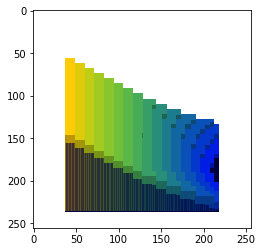

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '3'), ('Comment', 'Ascending Hole')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


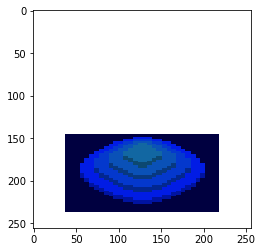

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '8'), ('Comment', 'Descending Hole')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


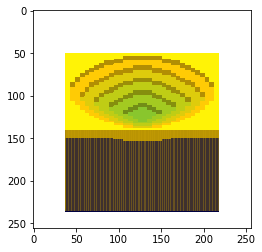

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '2'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


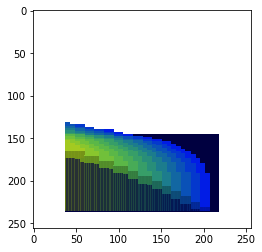

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '1'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


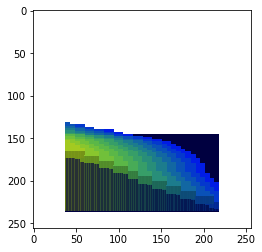

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '0'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


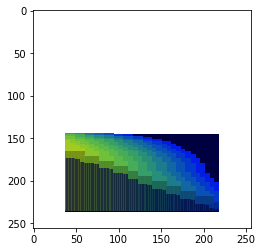

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '0'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


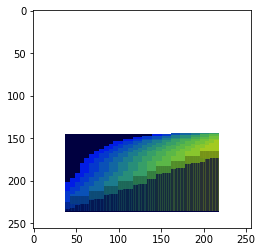

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '1'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


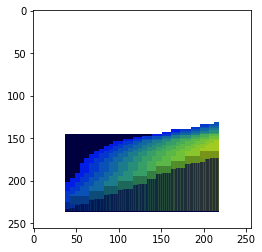

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '2'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


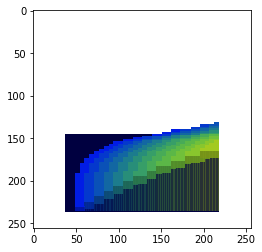

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '4'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


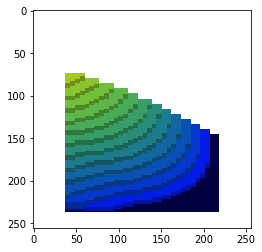

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '5'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


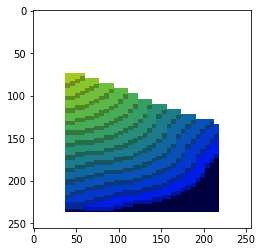

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '6'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


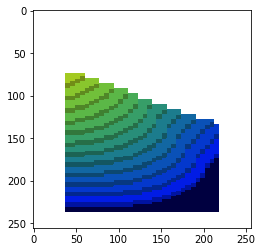

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '6'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


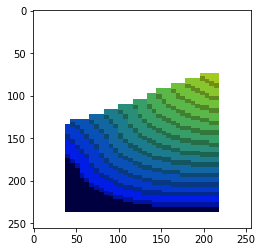

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '5'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


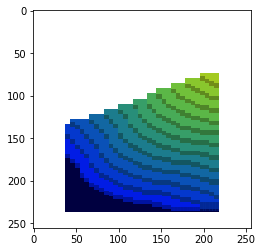

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '4'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


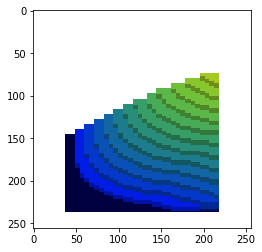

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '2'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


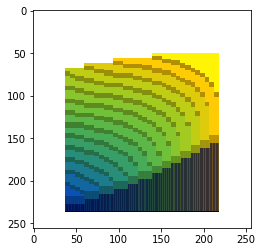

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '1'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


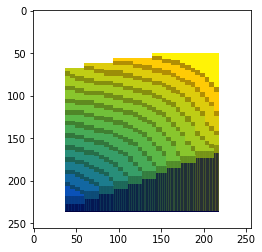

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '0'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


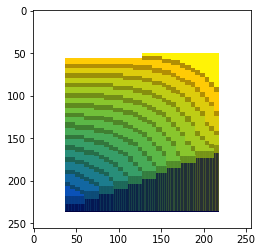

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '0'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


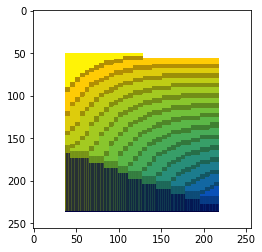

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '1'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


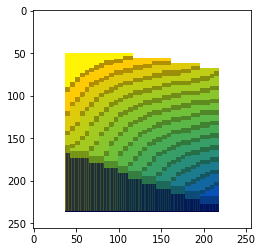

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '2'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


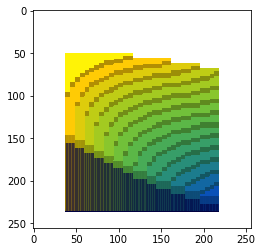

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '4'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


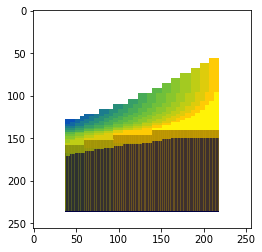

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '5'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


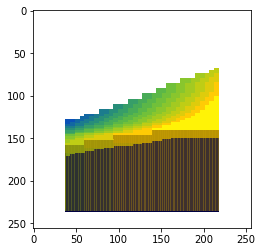

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '6'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


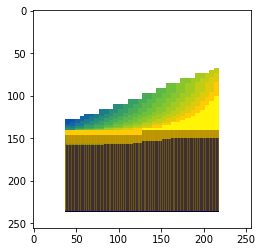

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '6'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


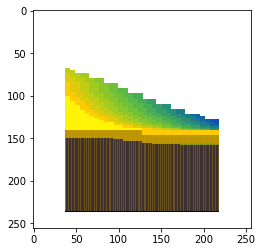

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '5'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


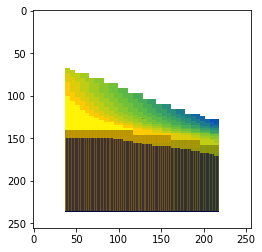

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '4'), ('Comment', '')])
sin_angle = -0.7071067811865477, cos_angle = 0.7071067811865474, cpls_angle = -3.3306690738754696e-16, cmns_angle = 1.414213562373095


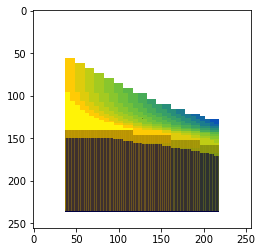

In [8]:
def draw_tile(hpos, vpos, scale=1., grad_offset=0, hfactor=1.5, show_floor=True, uvsub = 8, angle = math.pi/2.,):
    #x0 = iso_base_w * scale / 2
    #y0 = 0

    xbase = 0
    ybase = 0

    num_gray_levels = 16

    hoff = src_base_w * hpos
    voff = src_base_h * vpos

    sin_angle = math.sin(angle)
    cos_angle = math.cos(angle)
    cpls_angle = cos_angle + sin_angle
    cmns_angle = cos_angle - sin_angle
    radius_x = (iso_base_w * scale / 2)
    radius_y = (iso_base_h * scale / 2)

    print(f"sin_angle = {sin_angle}, cos_angle = {cos_angle}, cpls_angle = {cpls_angle}, cmns_angle = {cmns_angle}")

    pixmap = np.zeros((
        iso_base_w * tiles_scale * uvsub,
        iso_base_h * tiles_scale * uvsub * 2,
        4))

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 2), (0, 0, 0, 0))
    pixels = img.load()

    #x0 = radius_x
    #y0 = img.size[1]

    x0 = radius_x * (1. + sin_angle)
    y0 = img.size[1] - radius_y * (1. - cos_angle)

    max_vc = src_base_h * uvsub
    for raw_vc in range(max_vc):
        if cmns_angle >= 0:  vc = raw_vc
        else:                vc = max_vc - raw_vc - 1
        v = 1. - float(vc / src_base_h) / uvsub

        max_uc = src_base_w * uvsub
        for raw_uc in range(max_uc):
            if cpls_angle >= 0:  uc = raw_uc
            else:                uc = max_uc - raw_uc - 1
            u = 1. - float(uc / src_base_w) / uvsub

            #x = x0 + (iso_base_w * scale / 2) * ((1. - u) - (1. - v))
            #y = y0 - (iso_base_h * scale / 2) * ((1. - u) + (1. - v))

            #x = x0 + radius_x * (u - v)
            #y = y0 - radius_y * (u + v)

            x = x0 + radius_x * (u * cmns_angle - v * cpls_angle)
            y = y0 - radius_y * (u * cpls_angle + v * cmns_angle)

            vmap = hmap[uc // uvsub + hoff, vc // uvsub + voff]
            if vmap >= 1.: hlight = True
            else: hlight = False

            vmap = int(vmap * num_gray_levels) / num_gray_levels

            gr, gg, gb = gradient[min(grad_offset + int(vmap * 16), 15)]   

            if show_floor or vmap > 0:
                maxi = int(hfactor * scale * vmap * 32 + 1)
                for i in range(0, maxi):
                    if i == 0 and show_floor:
                        nr = 0
                        ng = 0
                        nb = 64
                        alpha = 1.
                    elif i < maxi - 1:
                        alpha = 0.3
                        if uc == max_uc - 1:
                            factor = 0.5
                        elif vc == max_vc - 1:
                            factor = 0.8
                        elif uc == 0:
                            factor = 0.5
                        elif vc == 0:
                            factor = 0.5
                        elif i >= maxi - 10:
                            factor = 0.7
                            alpha = 1.
                        else:
                            continue

                        nr = gr * factor
                        ng = gg * factor
                        nb = gb * factor
                    elif hlight:
                        nr = gr * 1.2
                        ng = gg * 1.2
                        nb = gb * 1.2
                        alpha = 1.
                    else:
                        nr = gr
                        ng = gg
                        nb = gb
                        alpha = 1.

                    tx = min(int(xbase + x), iso_base_w * tiles_scale - 1)
                    ty = min(int(ybase + y - i), iso_base_h * tiles_scale * 2 - 1)

                    if alpha < 0.01:
                        continue

                    if alpha < 0.99:
                        pr = pixmap[tx][ty][0]
                        pg = pixmap[tx][ty][1]
                        pb = pixmap[tx][ty][2]
                        palpha = pixmap[tx][ty][3]

                        nr = nr * alpha + pr * (1. - alpha) * palpha
                        ng = ng * alpha + pg * (1. - alpha) * palpha
                        nb = nb * alpha + pb * (1. - alpha) * palpha
                        alpha = 1. - (1. - alpha) * (1. - palpha)
                        
                    pixmap[tx][ty][0] = nr
                    pixmap[tx][ty][1] = ng
                    pixmap[tx][ty][2] = nb
                    pixmap[tx][ty][3] = alpha

                    try:
                        pixels[tx, ty] = (int(nr), int(ng), int(nb), int(255 * alpha))
                    except:
                        print(f"tx = {tx}, ty = {ty}")
                        raise

    return img, pixmap

tiles_scale = 2
for tile_info in tiles_info:
    print(tile_info)
    hpos, vpos = int(tile_info['XCoord']), int(tile_info['YCoord'])
    img, pixmap = draw_tile(hpos, vpos, scale=tiles_scale, angle= 7 * math.pi/4.)

    
    plt.imshow(img)
    plt.show()

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '7'), ('Comment', 'Floor')])


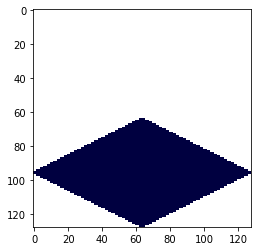

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '2'), ('Comment', 'Plateau')])


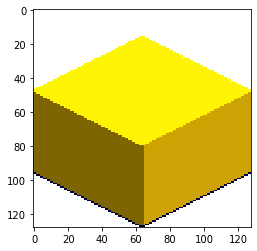

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '0'), ('Comment', 'Descending N-S')])


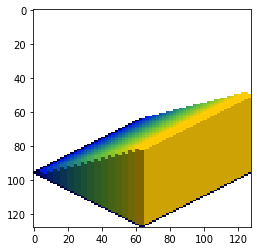

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '4'), ('Comment', 'Descending S-N')])


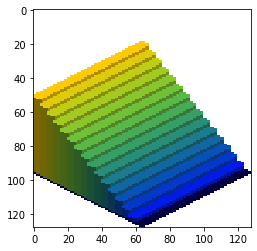

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '2'), ('Comment', 'Descending W-E')])


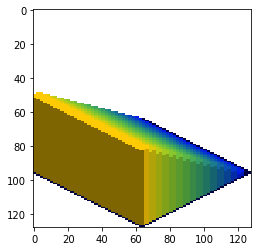

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '2'), ('Comment', 'Descending E-W')])


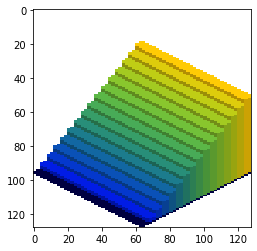

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '0'), ('Comment', 'Ascending Corner NW-SE')])


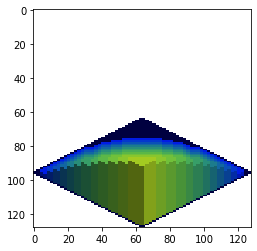

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '0'), ('Comment', 'Ascending Corner NE-SW')])


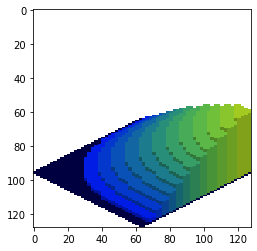

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '4'), ('Comment', 'Ascending Corner SW-NE')])


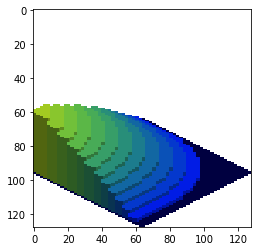

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '4'), ('Comment', 'Ascending Corner SE-NW')])


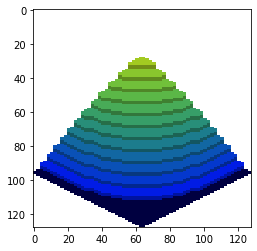

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '5'), ('Comment', 'Descending Corner NW-SE')])


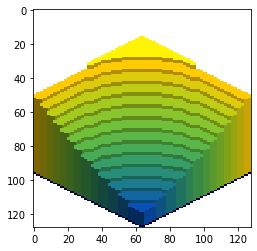

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '5'), ('Comment', 'Descending Corner NE-SW')])


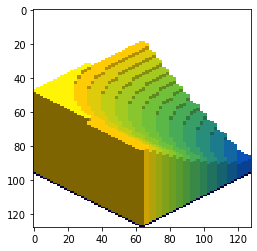

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '9'), ('Comment', 'Descending Corner SW-NE')])


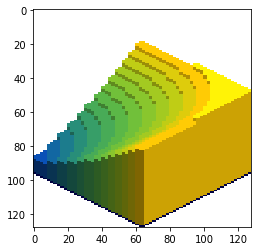

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '9'), ('Comment', 'Descending Corner SE-NW')])


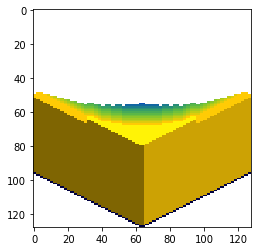

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '1'), ('Comment', 'Ascending Corner NWW-E')])


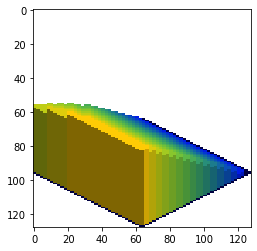

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '1'), ('Comment', 'Ascending Corner NEE-W')])


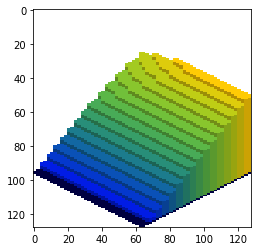

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '3'), ('Comment', 'Ascending Corner SWW-E')])


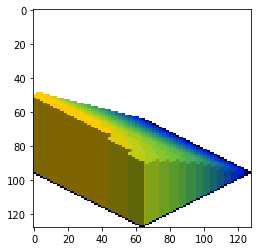

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '3'), ('Comment', 'Ascending Corner SEW-W')])


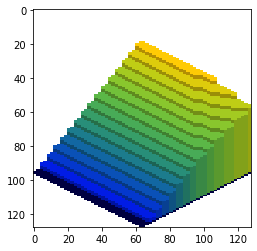

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNW-S')])


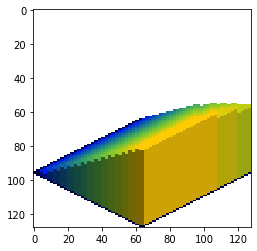

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNE-S')])


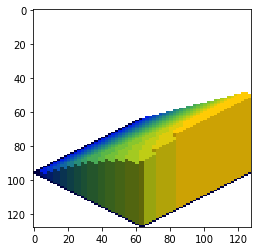

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSW-N')])


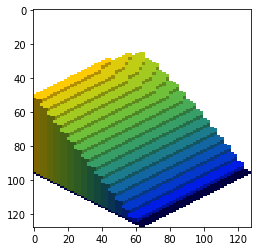

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSE-N')])


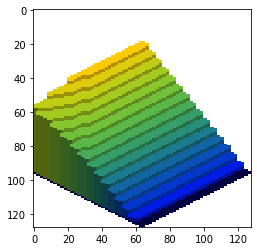

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '6'), ('Comment', 'Descending Corner NWW-E')])


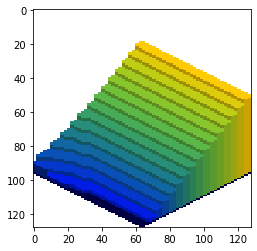

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '6'), ('Comment', 'Descending Corner NEE-W')])


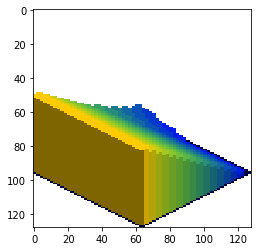

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '8'), ('Comment', 'Descending Corner SWW-E')])


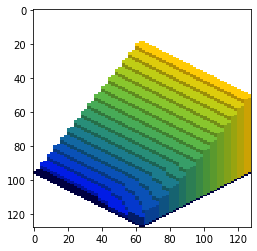

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '8'), ('Comment', 'Descending Corner SEW-W')])


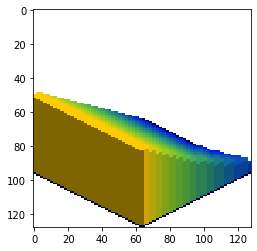

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '5'), ('Comment', 'Descending Corner NNW-S')])


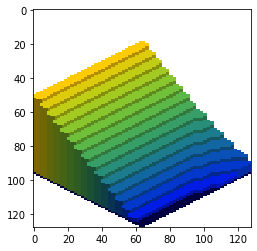

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '5'), ('Comment', 'Descending Corner NNE-S')])


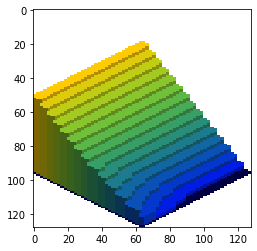

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '9'), ('Comment', 'Descending Corner SSW-N')])


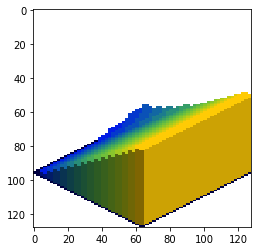

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '9'), ('Comment', 'Descending Corner SSE-N')])


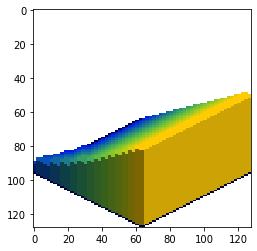

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '1'), ('Comment', 'Plateau NW')])


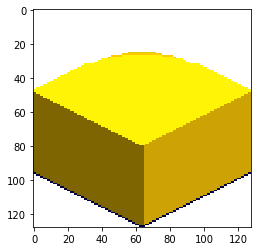

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '1'), ('Comment', 'Plateau NE')])


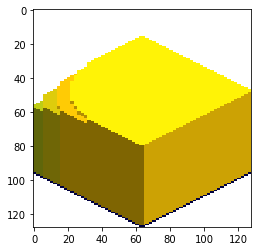

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '3'), ('Comment', 'Plateau SW')])


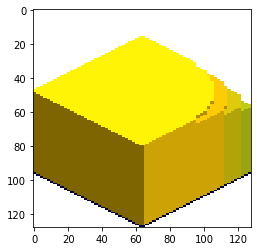

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '3'), ('Comment', 'Plateau SE')])


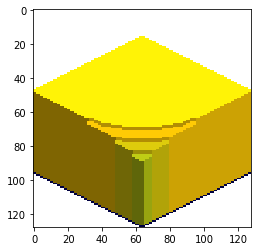

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '6'), ('Comment', 'Floor NW')])


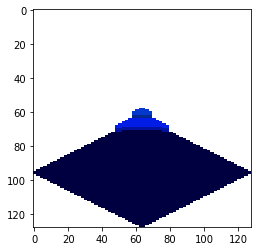

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '6'), ('Comment', 'Floor NE')])


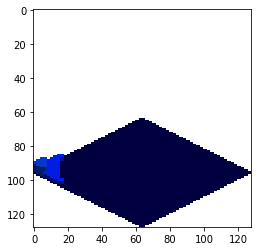

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '8'), ('Comment', 'Floor SW')])


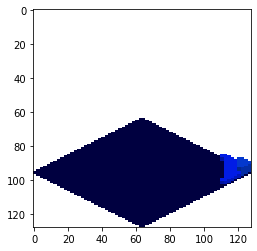

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '8'), ('Comment', 'Floor SE')])


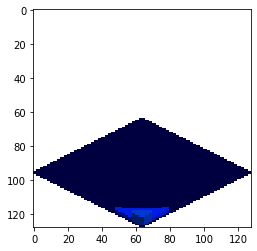

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '0'), ('Comment', 'Ascending Corner N')])


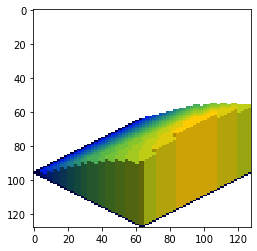

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '2'), ('Comment', 'Ascending Corner S')])


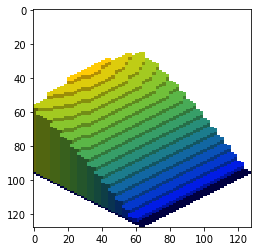

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '1'), ('Comment', 'Ascending Corner W')])


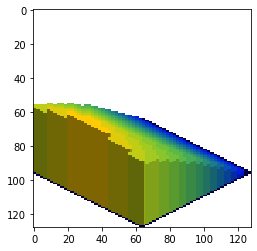

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '1'), ('Comment', 'Ascending Corner E')])


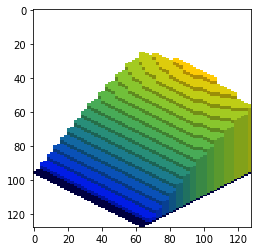

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '5'), ('Comment', 'Descending Corner N')])


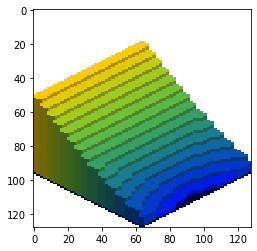

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '7'), ('Comment', 'Descending Corner S')])


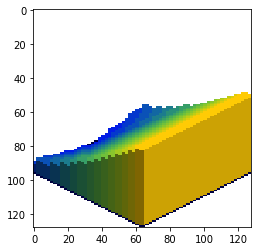

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '6'), ('Comment', 'Descending Corner W')])


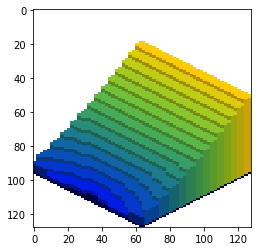

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '6'), ('Comment', 'Descending Corner E')])


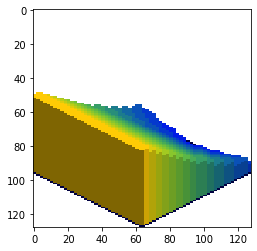

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '3'), ('Comment', 'Ascending Hole')])


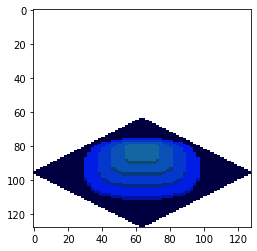

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '8'), ('Comment', 'Descending Hole')])


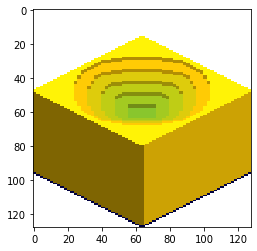

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '2'), ('Comment', '')])


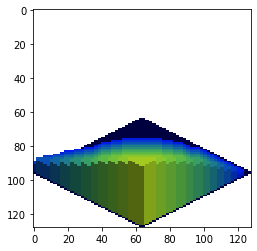

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '1'), ('Comment', '')])


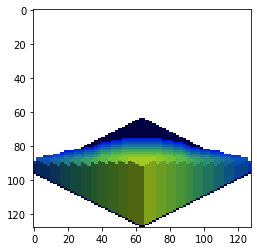

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '0'), ('Comment', '')])


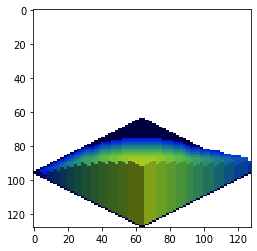

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '0'), ('Comment', '')])


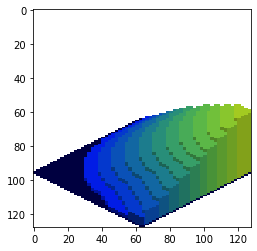

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '1'), ('Comment', '')])


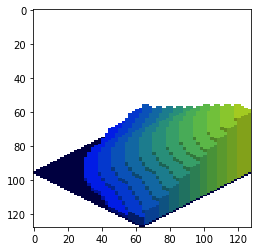

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '2'), ('Comment', '')])


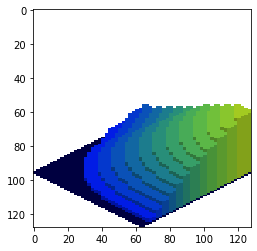

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '4'), ('Comment', '')])


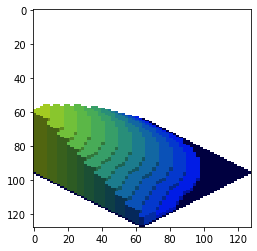

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '5'), ('Comment', '')])


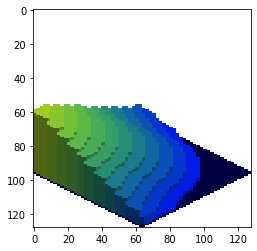

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '6'), ('Comment', '')])


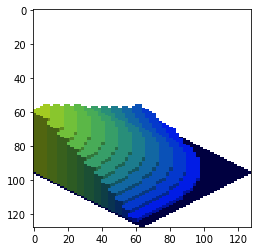

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '6'), ('Comment', '')])


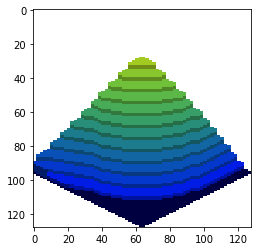

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '5'), ('Comment', '')])


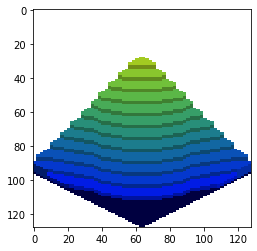

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '4'), ('Comment', '')])


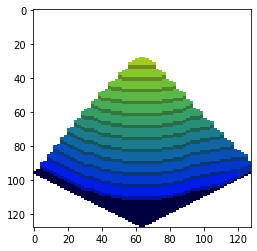

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '2'), ('Comment', '')])


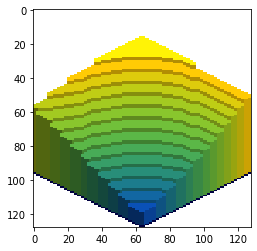

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '1'), ('Comment', '')])


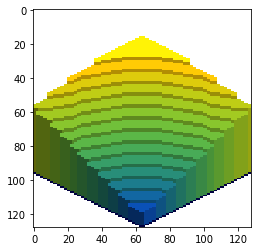

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '0'), ('Comment', '')])


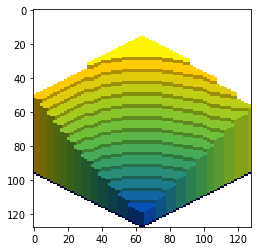

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '0'), ('Comment', '')])


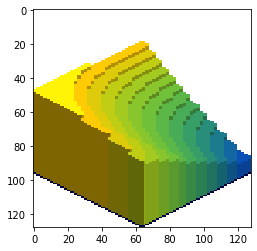

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '1'), ('Comment', '')])


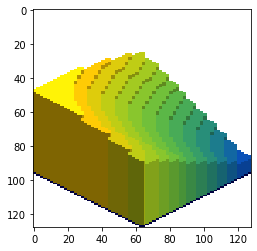

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '2'), ('Comment', '')])


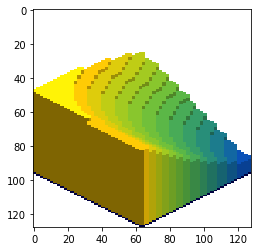

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '4'), ('Comment', '')])


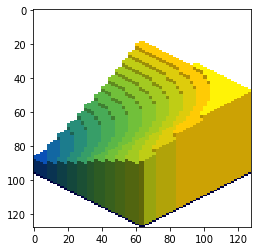

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '5'), ('Comment', '')])


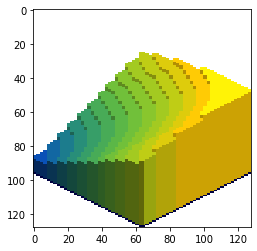

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '6'), ('Comment', '')])


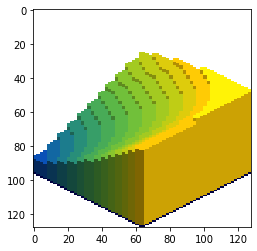

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '6'), ('Comment', '')])


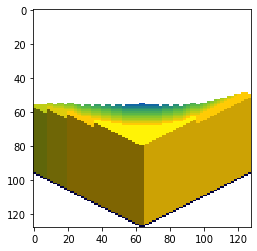

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '5'), ('Comment', '')])


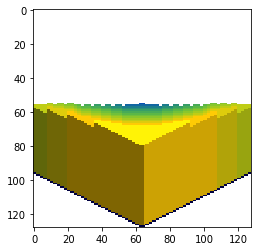

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '4'), ('Comment', '')])


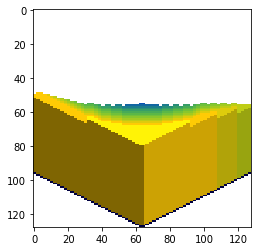

In [12]:
tiles_scale = 1
for tile_info in tiles_info:
    print(tile_info)
    hpos, vpos = int(tile_info['XCoord']), int(tile_info['YCoord'])

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 2), (0, 0, 0, 0))
    pixels = img.load()

    draw_tile(pixels, 0, 0, hpos, vpos, scale=tiles_scale, hfactor = 3.0)

    plt.imshow(img)
    plt.show()

In [13]:
mn = len(tiles_info)
mw = int(math.pow(2, math.ceil(math.log2(math.ceil(math.sqrt(mn))))))
mh = int(math.pow(2, math.ceil(math.log2(math.ceil(mn/mw)))))
print(f"Tile Map: Width={mw}, Height={mh} -> Size={mw*mh} (>={len(tiles_info)})")
tw = iso_base_w
th = iso_base_h * 2
print(f"Single Tile: Width={tw}, Height={th} -> Size={tw*th}")
print(f"Full Tile Sheet: Width={mw*tw}, Height={mh*th} -> Size={tw*th}")

Tile Map: Width=16, Height=8 -> Size=128 (>=72)
Single Tile: Width=128, Height=128 -> Size=16384
Full Tile Sheet: Width=2048, Height=1024 -> Size=16384


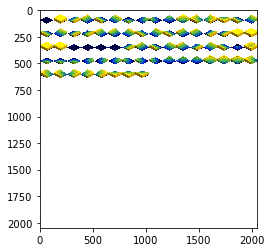

In [14]:
img = Image.new('RGBA', (tw*mw, th*mw), (0, 0, 0, 0))
pixels = img.load()
n0 = 0
for tile_num, tile_info in enumerate(tiles_info):
    x0 = tw * ((n0 + tile_num) % mw)
    y0 = th * ((n0 + tile_num) // mw) - img.size[1] + th
    draw_tile(pixels, x0, y0, int(tile_info['XCoord']), int(tile_info['YCoord']), uvsub = 2, scale = 1)
plt.imshow(img)
plt.show()

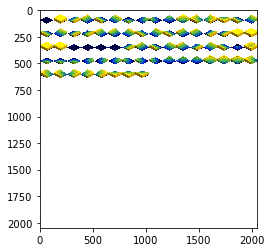

In [15]:
from io import BytesIO
png_data = BytesIO()
img.save(png_data, 'PNG')
#print(png_data.getvalue())
img.save('tmp_tiles.png')

read_img = Image.open('tmp_tiles.png', 'r')
plt.imshow(read_img)
plt.show()

[(0, 0, 128), (0, 200, 200), (250, 250, 0), (150, 250, 50), (250, 250, 0), (255, 150, 0), (255, 255, 0), (250, 0, 0), (150, 150, 50), (50, 50, 50), (250, 150, 100), (255, 255, 255)]
[[0, 0, 128], [5, 42, 138], [17, 78, 139], [33, 108, 134], [53, 134, 126], [72, 155, 116], [91, 173, 104], [109, 187, 93], [125, 198, 82], [140, 207, 72], [153, 213, 62], [165, 217, 53], [174, 219, 45], [185, 221, 39], [193, 220, 33], [200, 218, 28], [206, 215, 23], [211, 209, 18], [217, 206, 15], [219, 201, 14], [222, 193, 11], [225, 188, 10], [224, 180, 8], [225, 173, 9], [223, 165, 8], [222, 159, 9], [219, 150, 11], [215, 143, 12], [209, 135, 15], [205, 130, 18], [198, 124, 21], [192, 118, 25], [185, 113, 30], [181, 112, 36], [175, 109, 42], [168, 107, 47], [167, 109, 55], [166, 112, 64], [166, 115, 73], [169, 121, 83], [176, 130, 96], [184, 140, 109], [194, 152, 125], [208, 167, 143], [222, 186, 166], [237, 207, 191], [249, 230, 220], [255, 255, 255]]


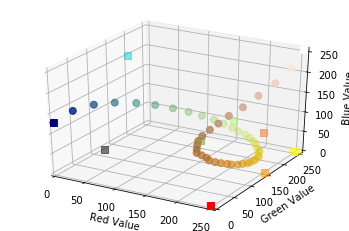

In [17]:
ref_colors = [(0,0,128), (0, 200, 200), (250, 250, 0), (150, 250, 50),
              (250, 250, 0), (255, 150, 0), (255, 255, 0), (250, 0 , 0),
              (150, 150, 50), (50, 50, 50), (250, 150, 100), (255, 255, 255)]

print(ref_colors)
num_colors = 3 * 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

Tile Map: Width=16, Height=16 -> Size=256 (>=72)
Single Tile: Width=128, Height=128 -> Size=16384
Full Tile Sheet: Width=2048, Height=2048 -> Size=16384


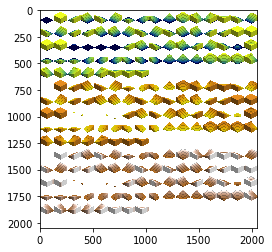

In [18]:
num_terrains = 3
scale = 1

mn = len(tiles_info) * num_terrains
mw = int(math.pow(2, math.ceil(math.log2(math.ceil(math.sqrt(mn))))))
mh = int(math.pow(2, math.ceil(math.log2(math.ceil(mn/mw)))))
print(f"Tile Map: Width={mw}, Height={mh} -> Size={mw*mh} (>={len(tiles_info)})")
tw = iso_base_w
th = iso_base_h * 2
print(f"Single Tile: Width={tw}, Height={th} -> Size={tw*th}")
print(f"Full Tile Sheet: Width={mw*tw}, Height={mh*th} -> Size={tw*th}")

img = Image.new('RGBA', (tw*mw, th*mw), (0, 0, 0, 0))
pixels = img.load()
n0 = 0
for i in range(num_terrains):
    for tile_num, tile_info in enumerate(tiles_info):
        x0 = tw * ((n0 + tile_num) % mw)
        y0 = th * ((n0 + tile_num) // mw) - img.size[1] + th
        draw_tile(pixels, x0, y0, int(tile_info['XCoord']), int(tile_info['YCoord']),
              uvsub=2, scale=scale, show_floor=(n0 == 0), hfactor=3, grad_offset=16*i)
    n0 += len(tiles_info)
    n0 = ((n0 + mw - 1) // mw) * mw
plt.imshow(img)
plt.show()

img.save('landh-tiles/tiles_test.png')

[(0, 0, 255), (0, 230, 64), (255, 203, 5)]
[[0, 0, 255], [1, 28, 229], [4, 56, 205], [10, 81, 183], [18, 103, 162], [28, 124, 141], [40, 142, 121], [55, 158, 104], [72, 171, 87], [91, 183, 71], [113, 192, 58], [137, 198, 45], [163, 202, 33], [191, 205, 21], [222, 204, 12], [255, 203, 5]]


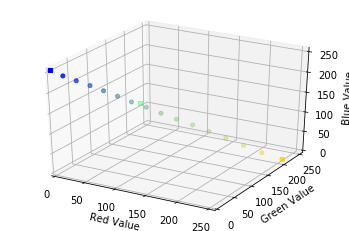

In [19]:
ref_colors = [(0,0,255), (0, 230, 64), (255, 203, 5)]

print(ref_colors)
num_colors = 256 // 16

gradient = bezier_gradient(ref_colors, num_colors)
print(gradient)

plot_gradient_series(color_dict(gradient),
                     pointsize=num_colors,
                     control_points=control_points_from_colors(ref_colors)
                    )

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '7'), ('Comment', 'Floor')])


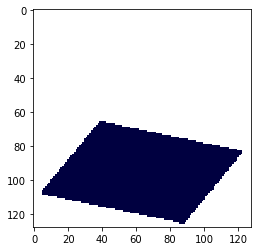

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '2'), ('Comment', 'Plateau')])


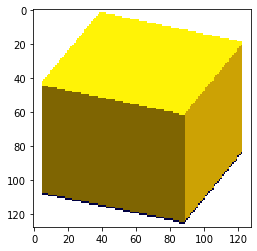

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '0'), ('Comment', 'Descending N-S')])


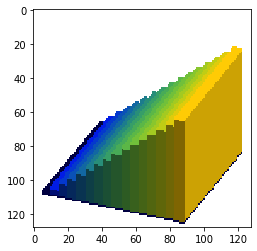

OrderedDict([('TileName', ''), ('XCoord', '2'), ('YCoord', '4'), ('Comment', 'Descending S-N')])


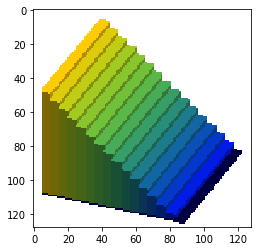

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '2'), ('Comment', 'Descending W-E')])


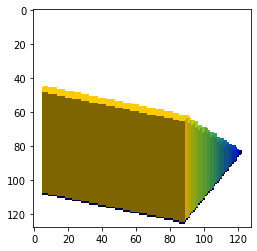

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '2'), ('Comment', 'Descending E-W')])


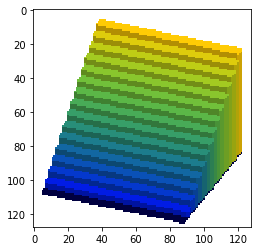

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '0'), ('Comment', 'Ascending Corner NW-SE')])


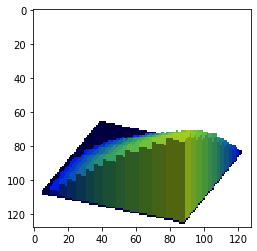

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '0'), ('Comment', 'Ascending Corner NE-SW')])


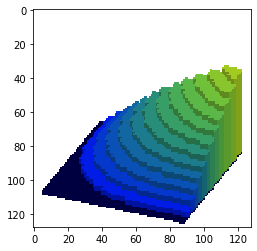

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '4'), ('Comment', 'Ascending Corner SW-NE')])


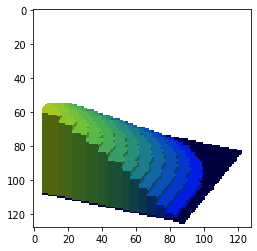

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '4'), ('Comment', 'Ascending Corner SE-NW')])


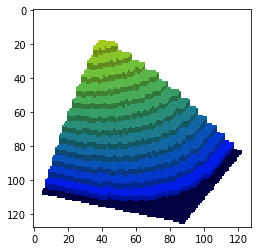

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '5'), ('Comment', 'Descending Corner NW-SE')])


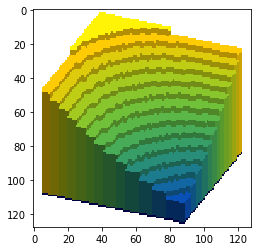

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '5'), ('Comment', 'Descending Corner NE-SW')])


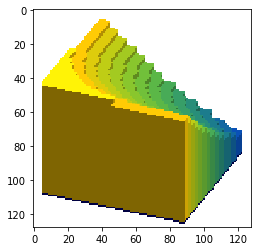

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '9'), ('Comment', 'Descending Corner SW-NE')])


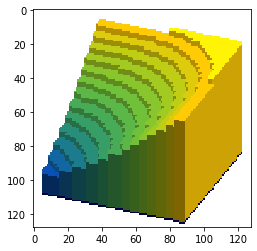

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '9'), ('Comment', 'Descending Corner SE-NW')])


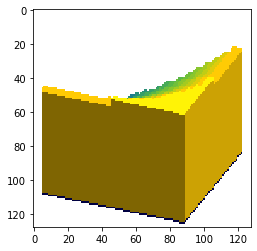

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '1'), ('Comment', 'Ascending Corner NWW-E')])


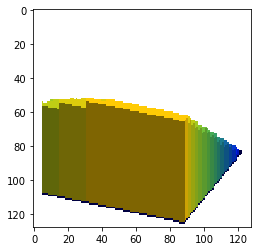

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '1'), ('Comment', 'Ascending Corner NEE-W')])


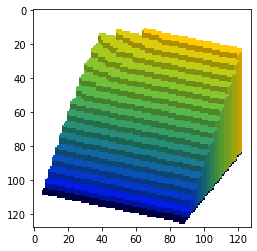

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '3'), ('Comment', 'Ascending Corner SWW-E')])


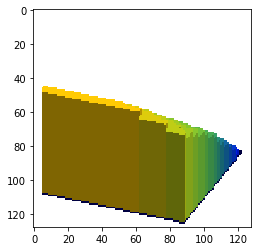

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '3'), ('Comment', 'Ascending Corner SEW-W')])


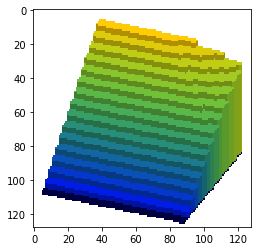

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNW-S')])


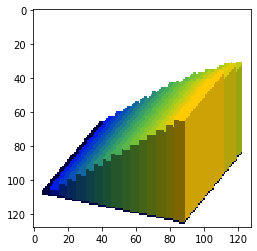

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '0'), ('Comment', 'Ascending Corner NNE-S')])


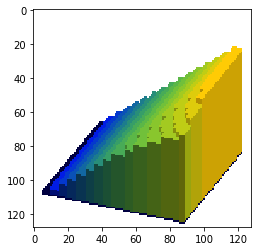

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSW-N')])


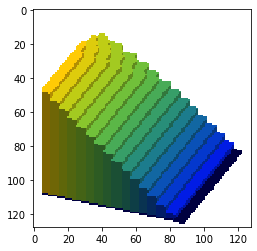

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '4'), ('Comment', 'Ascending Corner SSE-N')])


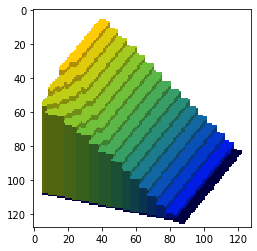

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '6'), ('Comment', 'Descending Corner NWW-E')])


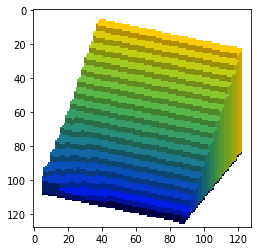

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '6'), ('Comment', 'Descending Corner NEE-W')])


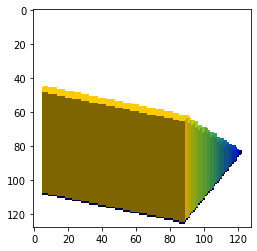

OrderedDict([('TileName', ''), ('XCoord', '0'), ('YCoord', '8'), ('Comment', 'Descending Corner SWW-E')])


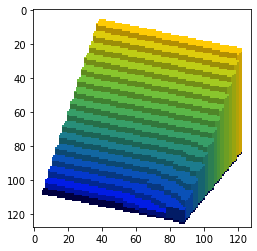

OrderedDict([('TileName', ''), ('XCoord', '4'), ('YCoord', '8'), ('Comment', 'Descending Corner SEW-W')])


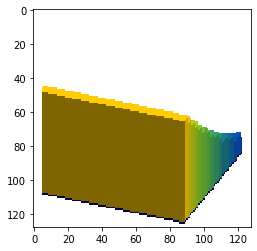

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '5'), ('Comment', 'Descending Corner NNW-S')])


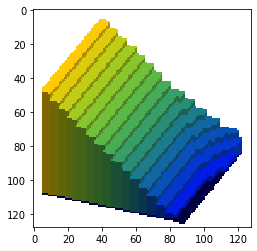

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '5'), ('Comment', 'Descending Corner NNE-S')])


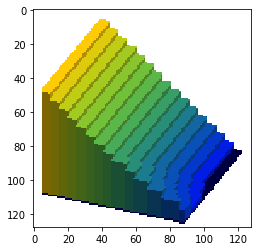

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '9'), ('Comment', 'Descending Corner SSW-N')])


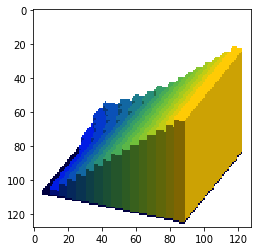

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '9'), ('Comment', 'Descending Corner SSE-N')])


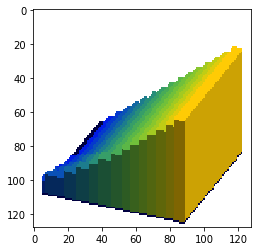

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '1'), ('Comment', 'Plateau NW')])


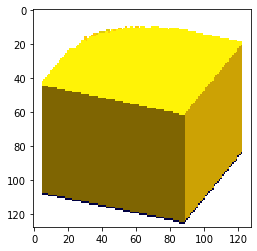

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '1'), ('Comment', 'Plateau NE')])


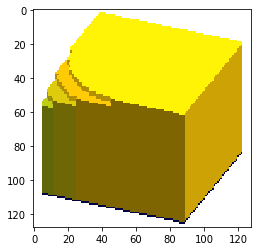

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '3'), ('Comment', 'Plateau SW')])


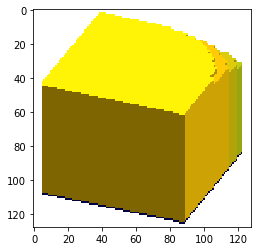

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '3'), ('Comment', 'Plateau SE')])


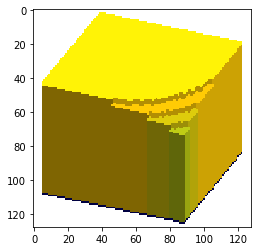

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '6'), ('Comment', 'Floor NW')])


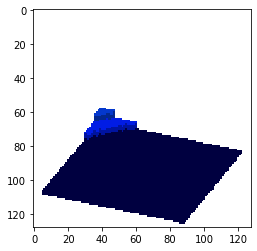

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '6'), ('Comment', 'Floor NE')])


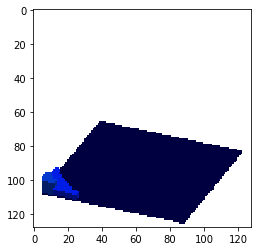

OrderedDict([('TileName', ''), ('XCoord', '1'), ('YCoord', '8'), ('Comment', 'Floor SW')])


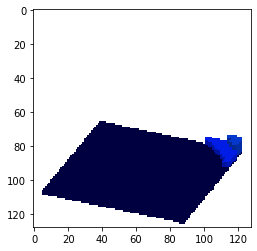

OrderedDict([('TileName', ''), ('XCoord', '3'), ('YCoord', '8'), ('Comment', 'Floor SE')])


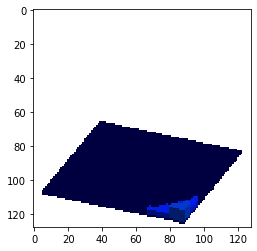

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '0'), ('Comment', 'Ascending Corner N')])


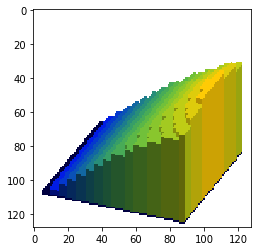

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '2'), ('Comment', 'Ascending Corner S')])


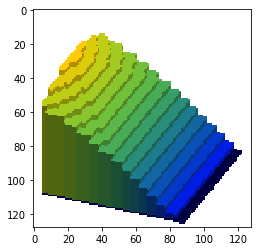

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '1'), ('Comment', 'Ascending Corner W')])


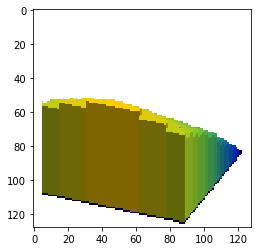

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '1'), ('Comment', 'Ascending Corner E')])


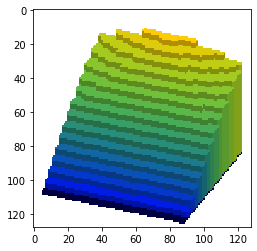

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '5'), ('Comment', 'Descending Corner N')])


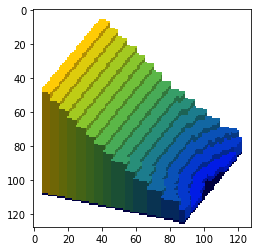

OrderedDict([('TileName', ''), ('XCoord', '6'), ('YCoord', '7'), ('Comment', 'Descending Corner S')])


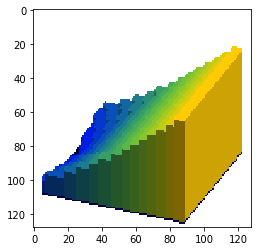

OrderedDict([('TileName', ''), ('XCoord', '5'), ('YCoord', '6'), ('Comment', 'Descending Corner W')])


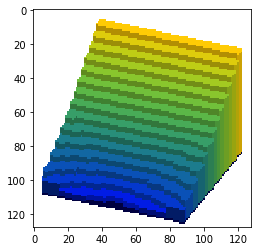

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '6'), ('Comment', 'Descending Corner E')])


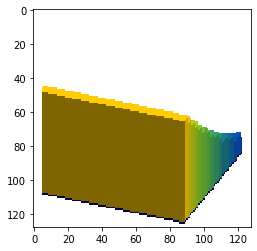

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '3'), ('Comment', 'Ascending Hole')])


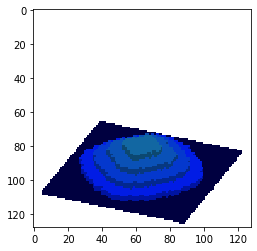

OrderedDict([('TileName', ''), ('XCoord', '7'), ('YCoord', '8'), ('Comment', 'Descending Hole')])


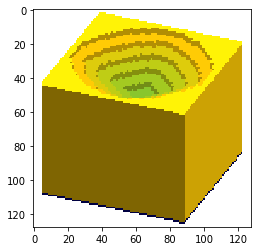

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '2'), ('Comment', '')])


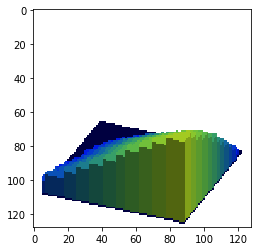

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '1'), ('Comment', '')])


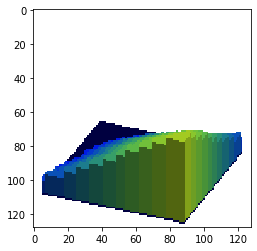

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '0'), ('Comment', '')])


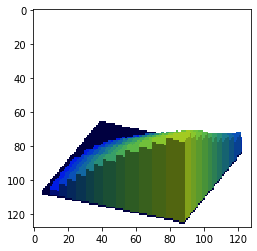

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '0'), ('Comment', '')])


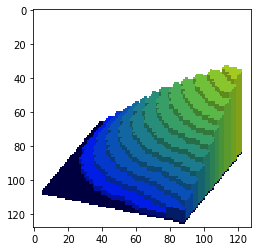

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '1'), ('Comment', '')])


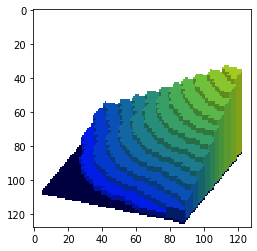

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '2'), ('Comment', '')])


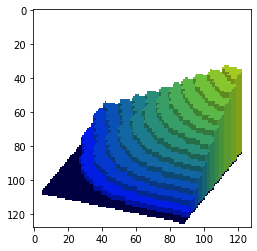

OrderedDict([('TileName', ''), ('XCoord', '10'), ('YCoord', '4'), ('Comment', '')])


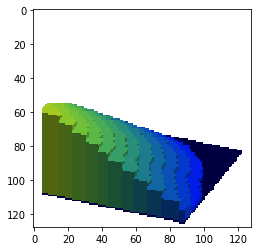

OrderedDict([('TileName', ''), ('XCoord', '11'), ('YCoord', '5'), ('Comment', '')])


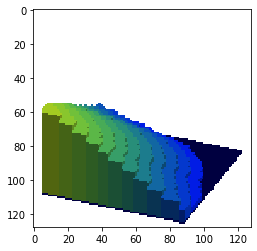

OrderedDict([('TileName', ''), ('XCoord', '12'), ('YCoord', '6'), ('Comment', '')])


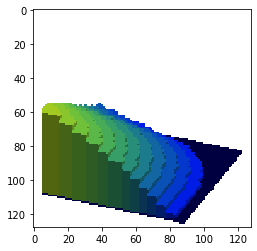

OrderedDict([('TileName', ''), ('XCoord', '14'), ('YCoord', '6'), ('Comment', '')])


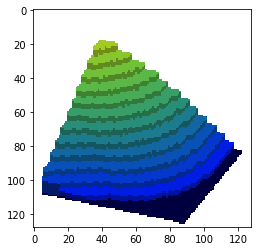

OrderedDict([('TileName', ''), ('XCoord', '15'), ('YCoord', '5'), ('Comment', '')])


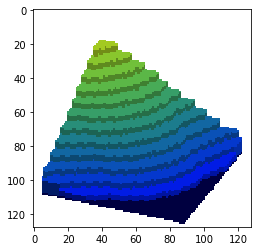

OrderedDict([('TileName', ''), ('XCoord', '16'), ('YCoord', '4'), ('Comment', '')])


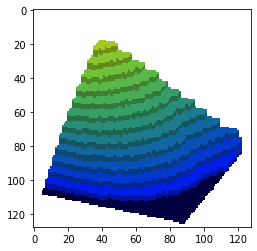

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '2'), ('Comment', '')])


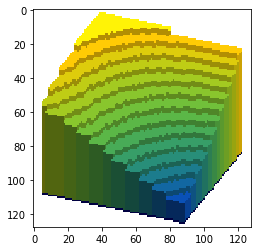

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '1'), ('Comment', '')])


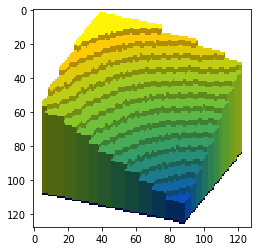

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '0'), ('Comment', '')])


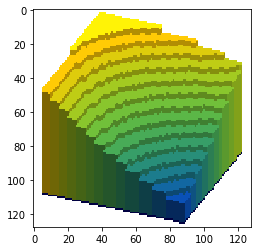

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '0'), ('Comment', '')])


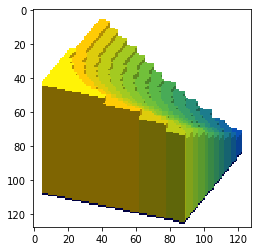

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '1'), ('Comment', '')])


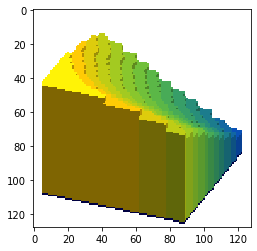

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '2'), ('Comment', '')])


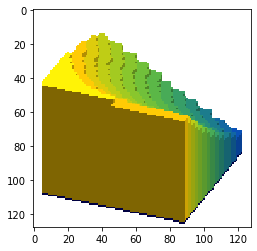

OrderedDict([('TileName', ''), ('XCoord', '17'), ('YCoord', '4'), ('Comment', '')])


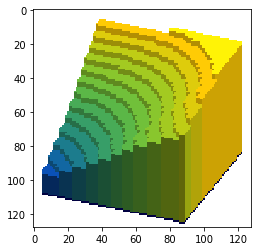

OrderedDict([('TileName', ''), ('XCoord', '18'), ('YCoord', '5'), ('Comment', '')])


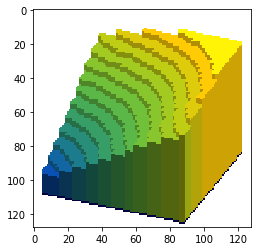

OrderedDict([('TileName', ''), ('XCoord', '19'), ('YCoord', '6'), ('Comment', '')])


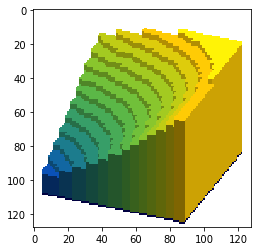

OrderedDict([('TileName', ''), ('XCoord', '21'), ('YCoord', '6'), ('Comment', '')])


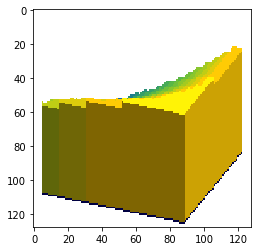

OrderedDict([('TileName', ''), ('XCoord', '22'), ('YCoord', '5'), ('Comment', '')])


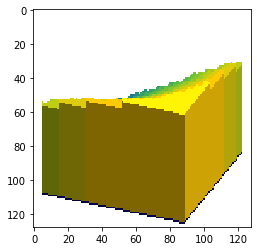

OrderedDict([('TileName', ''), ('XCoord', '23'), ('YCoord', '4'), ('Comment', '')])


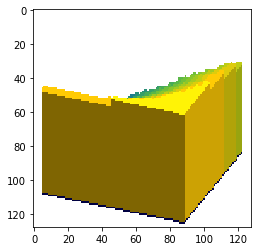

In [41]:
import math

def draw_tile(pixels, xbase, ybase, hpos, vpos, alpha = math.pi/8.,
              show_floor = True, scale = 2, uvsub = 8, hfactor = 1, grad_offset = 0):

    hoff = src_base_w * hpos
    voff = src_base_h * vpos

    sin_alpha = math.sin(alpha)
    cos_alpha = math.cos(alpha)
    cpls_alpha = cos_alpha + sin_alpha
    cmns_alpha = cos_alpha - sin_alpha
    radius_x = (iso_base_w * scale / 2)
    radius_y = (iso_base_h * scale / 2)

    #x0 = radius_x
    #y0 = img.size[1]

    x0 = radius_x * (1. + sin_alpha)
    y0 = img.size[1] - radius_y * (1. - cos_alpha)

    uvsub = 8
    max_vc = src_base_h * uvsub
    for vc in range(max_vc):
        v = 1. - float(vc / src_base_h) / uvsub
        max_uc = src_base_w * uvsub
        for uc in range(max_uc):
            u = 1. - float(uc / src_base_h) / uvsub
            
            #x = x0 + radius_x * (u - v)
            #y = y0 - radius_y * (u + v)

            x = x0 + radius_x * (u * cmns_alpha - v * cpls_alpha)
            y = y0 - radius_y * (u * cpls_alpha + v * cmns_alpha)
            
            rmap, gmap, bmap, amap = rgb_im_v.getpixel((uc // uvsub + hoff, vc // uvsub + voff))
            num = 16
            vmap = max(rmap, gmap, bmap)
            hlight = False
            if vmap >= 255: 
                vmap = 256
                hlight = True
            vmap = int(min(num - 0, vmap * num / 256 )) * 32 // num // 2
            gr, gg, gb = gradient[grad_offset + max(rmap, gmap, bmap) // 16]

            if show_floor or vmap > 0:
                maxi = int(hfactor * scale * vmap + 1)
                for i in range(0, maxi):
                    if i == 0 and show_floor:
                        nr = 0
                        ng = 0
                        nb = 64
                        na = 255
                    elif i < maxi - 1:
                        factor = 0.7
                        if uc == max_uc - 1:
                            factor = 0.5
                        elif vc == max_vc - 1:
                            factor = 0.8
                        nr = gr * factor
                        ng = gg * factor
                        nb = gb * factor
                        na = 255
                    elif hlight:
                        nr = gr * 1.2
                        ng = gg * 1.2
                        nb = gb * 1.2
                        na = 255
                    else:
                        nr = gr
                        ng = gg
                        nb = gb
                        na = 255

                    pixels[xbase + x, ybase + y - i] = (int(nr), int(ng), int(nb), int(na))

tiles_scale = 1
for tile_info in tiles_info:
    print(tile_info)
    hpos, vpos = int(tile_info['XCoord']), int(tile_info['YCoord'])

    img = Image.new('RGBA', (iso_base_w * tiles_scale, iso_base_h * tiles_scale * 2), (0, 0, 0, 0))
    pixels = img.load()

    draw_tile(pixels, 0, 0, hpos, vpos, scale = tiles_scale, uvsub = 8, hfactor = 4)

    plt.imshow(img)
    plt.show()